In [1]:
using DataFrames
using CSV
using Glob
using Chain
using Statistics
using SimSpread
using ArgParse
using Base.Threads
using MLBase
using ProgressMeter
using AlgebraOfGraphics
using CairoMakie
using Plots
using StatsPlots
# include("getmetrics.jl")
using MLJ
using ProgressMeter
# using Base.Threads

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA ~/.julia/packages/CUDA/s0e3j/src/initialization.jl:70


In [2]:
function gobl(path::String)
    files = glob("*.out", path)
    df = DataFrame()
    
    for file in files
    # extract
    α = @chain file begin
        basename
        replace(".out" => "")
        split('.')
        last
        split('_')
        last
        end
    
    α_value = if startswith(α, "00")
              parse(Float64, α, ) / 100
          else
              parse(Float64, α) / 10
          end
 
    
    # file to df
    file_df = CSV.File(file, delim=",", header=["Fold", "Ligando", "Target", "Score", "TP"]) |> DataFrame
    
    # add alpha 
    file_df[!, "Alpha"] .= α_value
    
    append!(df, file_df)
    end
    
    return df
end


function rescore(df::DataFrame)
    df = @chain df begin
        groupby([:Fold, :Ligando, :Target, :TP, :Alpha])    
        combine(:Score => sum => :Score)
        unstack(:Alpha, :Score)
    end
    return df
end


function rescore(df::DataFrame, fxs::Vector{Function}, benchmark::String="0.2")
    symbs = []
    
    uniq = df[:, :Alpha]
    tcols = size(unique(uniq))[1] + ncol(df) - 3
    
    for f in fxs
        push!(symbs, String(Symbol(f)))
    end
    
    df_2 = @chain df begin
        groupby([:Fold, :Ligando, :Target, :TP, :Alpha])    
        combine(:Score => sum => :Score)
        unstack(:Alpha, :Score)
        DataFrames.transform(AsTable(5:tcols) .=> ByRow.(fxs) .=> symbs)
        select(1:4, [benchmark], symbs)
    end
    return df_2
end

function train_rescore(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, model="0", benchmark::String="0.2"; args...)
    symbs = []
    
    uniq = df[:, :Alpha]
    tcols = size(unique(uniq))[1] + ncol(df) - 3
    
    fxm_name = String(Symbol(model))
    
    for f in fxs
        push!(symbs, String(Symbol(f)))
    end
    
#     prepare test set
    df = rescore(df)
#     prepare training set with rng seed to shuffle rows
    df_train = rescore(df_train)
    
    if model != "0"
    #     scitypes and prepare data
        y, X =  prepare_machine(df_train; rng=123)

        # train machine and get parameters
        Model = model
        model = Model()
        mach = machine(model(;args...), X, y)
        m1 = fit!(mach)
        params = fitted_params(m1)

    #     MLJ based transformation of test dataframe to make predictions
        y, X =  prepare_machine(df)
        
    #     predict
        yhat = MLJ.predict_mode(m1, X)

        df = @chain df begin
            DataFrames.transform(AsTable(5:tcols) .=> ByRow.(fxs) .=> symbs)
            select(1:4, [benchmark], symbs)
        end
        df[!, fxm_name] = yhat
    else
        df = @chain df begin
            DataFrames.transform(AsTable(5:tcols) .=> ByRow.(fxs) .=> symbs)
            select(1:4, [benchmark], symbs)
        end
    end
    if model == "0"
        params = 0
    end
    return df, params
end

function prepare_machine(df::DataFrame; args...)

    #     this is for scitype compatibility with machine
    df = select(df, 4:ncol(df))
    df[!, 2:end] = convert.(Float64, df[!, 2:end])
    df = coerce(df, :TP=>Multiclass)
    y, X = unpack(df, ==(:TP); args...)
    return y, X
end

function log_reg()
#     instantiate model
    return @iload LogisticClassifier pkg=MLJLinearModels verbosity=0
end

function rf_class()
#     instantiate model
     return @iload RandomForestClassifier pkg=DecisionTree verbosity=0
end

function xgb_class()
#     instantiate model
     return @iload XGBoostClassifier pkg=XGBoost verbosity=0
end


function evaluate(df::DataFrame, fxs::Vector{Function}, yhat="0", benchmark::String="0.2")
    df_f = DataFrame()
    
    symbs = []
    for f in fxs
        push!(symbs, String(Symbol(f)))
    end
    push!(symbs, benchmark)
    
#     if using ml model, and model function is provided, add function name 
    if yhat != "0"
        push!(symbs, String(Symbol(yhat)))
    else
        
    end
    
    for metric in symbs
        df_t = @chain df begin
            select(["Fold", "Ligando", "Target", "TP" , metric])
            rename!(5 => :Score)
        end
        
        df_m = getperformance(df_t)
        df_m.groupid = replace(df_m.groupid, missing => metric)
        append!(df_f, df_m)
    end
    
    return df_f
end


function plotmetrics(df::DataFrame, benchmark::String="0.2")
    gr()
        
    df_plot = @chain df begin
        stack(names(df[:, 2:end]), :groupid)
    unstack(:groupid, :value)
    rename!(:variable => :metric)
    end
    
    df_perct = copy(df_plot)
    for n in 2:ncol(df_perct)
    df_perct[:, n] .= (df_plot[:, n] .- df_plot[:,benchmark]) ./ df_plot[:,benchmark]
    end
    
    plot1 = @df df_plot groupedbar(
    :metric,
    cols(2:ncol(df_plot)),
    bar_width=0.7,
    framestyle = :box,
    lw = 0,
    guidefontsize = 8,
    )
    
    plot2 = @df df_perct groupedbar(
    :metric,
    cols(2:ncol(df_plot)),
    bar_width=0.7,
    framestyle = :box,
    lw = 0,
    guidefontsize = 8,
    )
    
    return plot1, plot2, df_plot, df_perct
end;

# getmetrics.jl functions

function getperformance(
    df::DataFrame;
    ycol::String="TP",
    yhatcol::String="Score",
#   estoy agregando columna ligandos para funcion r@ y p@
    ligcol::String="Ligando"
)
    # Initialize function
    score = convert(Vector{Float64}, df[!, yhatcol])
    tp = convert(Vector{Bool}, df[!, ycol])
#   grouping para la nueva funcion
    grouping = df[!, ligcol]

    # Generate confusion matrix and common metrics
    thresholds = sort(unique(score))

    confusion =MLBase.roc(tp, score, thresholds)
    recalls = SimSpread.recall.(confusion)
    precisions = SimSpread.precision.(confusion)
    tprs =MLBase.true_negative_rate.(confusion)
    fprs =MLBase.false_negative_rate.(confusion)

    # Standard metrics
    auprc = SimSpread.AuPRC(tp, score)
    auroc = SimSpread.AuROC(tp, score)

    # Early recognition
    bedroc = SimSpread.BEDROC(tp, score)
#     agregando implementacion de r@20 y p@20 de update de SimSpread 03/04/2023
    r20 = SimSpread.recallatL(tp, score, grouping, 20)
    p20 = SimSpread.precisionatL(tp, score, grouping, 20)

    # Binary metrics
    f1 = SimSpread.maxperformance(confusion, SimSpread.f1score)
    bacc = SimSpread.maxperformance(confusion, SimSpread.balancedaccuracy)
    acc = SimSpread.maxperformance(confusion, SimSpread.accuracy)
    mcc = SimSpread.maxperformance(confusion, SimSpread.mcc)

    return DataFrame(
        groupid=[missing],
        AuROC=[auroc],
        AuPRC=[auprc],
        BEDROC=[bedroc],
        r20 = [r20],
        p20 = [p20],
        f1=[f1],
        bacc=[bacc],
        acc=[acc],
        mcc = [mcc],
    )
end

function getperformance(
    df::DataFrame,
    groupby::String;
    ycol::String="TP",
    yhatcol::String="Score"
)
    # Initialize function
    grouper = df[!, groupby]
    alltp = convert(Vector{Bool}, df[!, ycol])
    allscore = convert(Vector{Float64}, df[!, yhatcol])

    # Evaluate performance per group
    groupperformance = DataFrame()
    for groupᵢ in unique(grouper)
        # Get group scores and true-positive state
        tp = alltp[grouper.==groupᵢ]
        score = allscore[grouper.==groupᵢ]

        # Confusion matrix
        thresholds = sort(unique(score))

        confusion =MLBase.roc(tp, score, thresholds)
        recalls = SimSpread.recall.(confusion)
        precisions = SimSpread.precision.(confusion)
        tprs =MLBase.true_negative_rate.(confusion)
        fprs =MLBase.false_negative_rate.(confusion)

        # Standard metrics
        auprc = SimSpread.AuPRC(tp, score)
        auroc = SimSpread.AuROC(tp, score)

        # Early recognition
        bedroc = SimSpread.BEDROC(tp, score)
        # r20 = SimSpread.performanceatL(tp, score, SimSpread.recall)
        # p20 = SimSpread.performanceatL(tp, score, SimSpread.precision)

        # Binary metrics
        f1 = SimSpread.maxperformance(confusion, SimSpread.f1score)
        bacc = SimSpread.maxperformance(confusion, SimSpread.balancedaccuracy)
        acc = SimSpread.maxperformance(confusion, SimSpread.accuracy)
        # mcc = SimSpread.maxperformance(confusion, SimSpread.mcc)

        append!(
            groupperformance,
            DataFrame(
                groupid=[groupᵢ],
                AuROC=[auroc],
                AuPRC=[auprc],
                BEDROC=[bedroc],
                # r20 = [r20],
                # p20 = [p20],
                f1=[f1],
                bacc=[bacc],
                acc=[acc],
                # mcc = [mcc],
            )
        )
    end

    return groupperformance
end

getperformance (generic function with 2 methods)

In [3]:
function allmetrics(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, fxm="0", benchmark::String="0.2"; args...)
    """
    df: test dataframe
    df_train: training dataframe
    fxs: vector of functions to apply
    fxm: model function to provide Data_Type() of MLJ model. Default to "0" doesn't apply model fit and predictions 
    benchmark:: NBI algorithm alpha value to benchmark performance.
    
    """
    df1, params = train_rescore(df, df_train, fxs, fxm, benchmark; args...)
    df2 = evaluate(df1, fxs, fxm, benchmark)
    plot1, plot2, df_plot, df_perct = plotmetrics(df2, benchmark)
    display(plot1)
    display(plot2)
    return params, df_plot, df_perct
end
    

allmetrics (generic function with 3 methods)

In [4]:
path = "/CLUSTERFS/homes/fnmelo/Bioinf_2"
df = gobl(path)

Row,Fold,Ligando,Target,Score,TP,Alpha
,Int64,String15,String15,Float64,Float64,Float64
1,1,CHEMBL1062,CHEMBL1075132,2.27353e-5,0.0,0.0
2,1,CHEMBL1062,CHEMBL1075145,5.10256e-6,0.0,0.0
3,1,CHEMBL1062,CHEMBL1075165,2.16946e-5,0.0,0.0
4,1,CHEMBL1062,CHEMBL1075323,9.05151e-6,0.0,0.0
5,1,CHEMBL1062,CHEMBL1163125,4.21232e-5,0.0,0.0
6,1,CHEMBL1062,CHEMBL1250378,6.50849e-6,0.0,0.0
7,1,CHEMBL1062,CHEMBL1293224,1.6584e-5,0.0,0.0
8,1,CHEMBL1062,CHEMBL1293226,2.15297e-5,0.0,0.0
9,1,CHEMBL1062,CHEMBL1293267,2.88745e-5,0.0,0.0


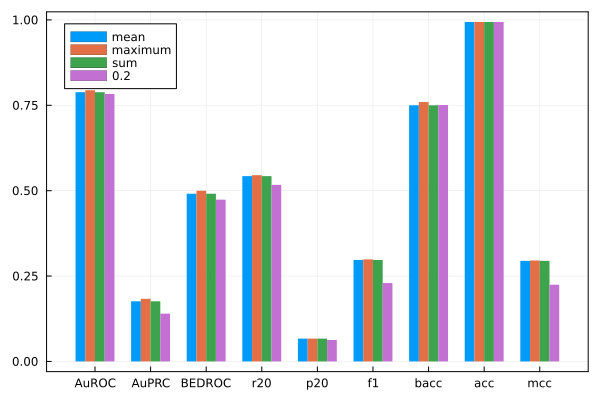

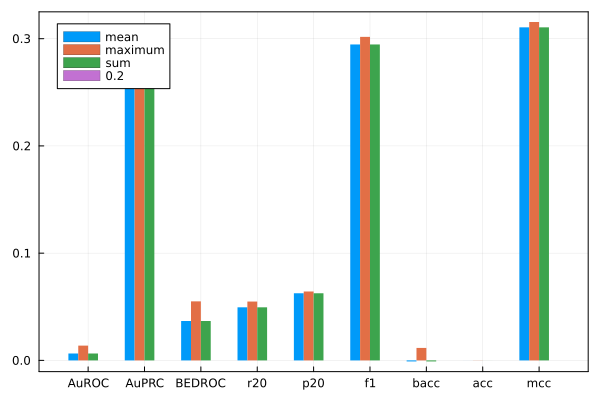

(0, 9×5 DataFrame
 Row │ metric  mean       maximum    sum        0.2       
     │ String  Float64?   Float64?   Float64?   Float64?  
─────┼────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286
   2 │ AuPRC   0.176055   0.183345   0.176055   0.13993
   3 │ BEDROC  0.491086   0.49976    0.491086   0.473685
   4 │ r20     0.542592   0.545372   0.542592   0.517002
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364
   6 │ f1      0.297174   0.298799   0.297174   0.229549
   7 │ bacc    0.750061   0.759519   0.750061   0.750781
   8 │ acc     0.993862   0.993946   0.993862   0.993846
   9 │ mcc     0.294465   0.295586   0.294465   0.224686, 9×5 DataFrame
 Row │ metric  mean          maximum      sum           0.2      
     │ String  Float64?      Float64?     Float64?      Float64? 
─────┼───────────────────────────────────────────────────────────
   1 │ AuROC    0.0064345    0.0137839     0.0064345         0.0
   2 │ AuPRC  

In [8]:
# testing without model
fxs = [mean, maximum, sum]
allmetrics(df, df, fxs)

In [5]:
# search for models compatible with datatypes, is native julia and based on keyword
y, X = prepare_machine(rescore(df))
compatible_models = models(matching(X, y))

filter(
#     check for pure julia models
    m -> m.is_pure_julia && 
             contains(m.docstring * m.name, "logistic"),
    compatible_models
)

1-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = LogisticClassifier, package_name = MLJLinearModels, ... )

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


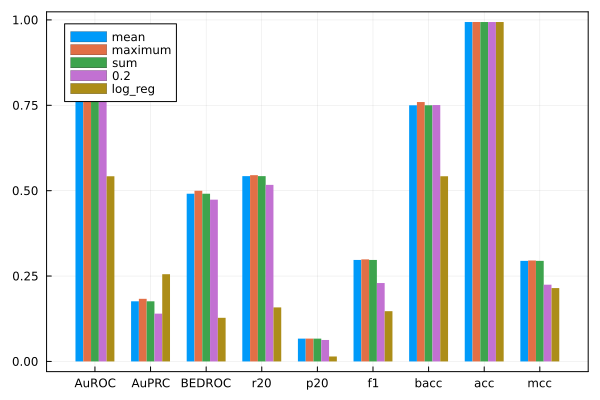

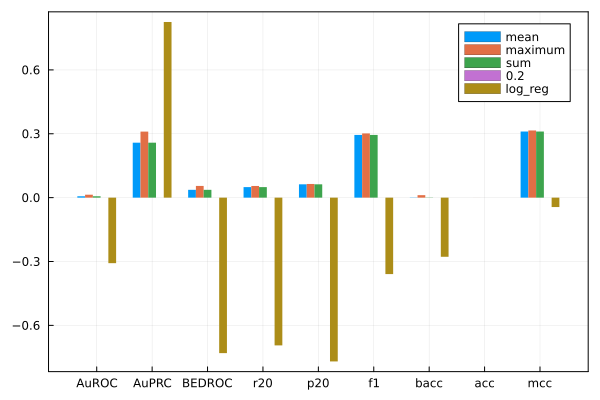

((classes = CategoricalArrays.CategoricalValue{Float64, UInt32}[0.0, 1.0], coefs = [Symbol("0.0") => 1.5835221789901235, Symbol("0.05") => 1.7836683034425276, Symbol("0.1") => 4.2286621815798675, Symbol("1.5") => 11.16443396017719, Symbol("0.2") => 54.29827361456457, Symbol("2.5") => 15.404011035527429, Symbol("0.3") => 10.370207689426486, Symbol("3.5") => 15.8251331808297, Symbol("0.4") => 2.310115190147128, Symbol("4.5") => -2.3428034741915664  …  Symbol("5.5") => -20.22683919581722, Symbol("0.6") => 4.798470947287473, Symbol("6.5") => 10.092448901814668, Symbol("0.7") => -3.1575132975251883, Symbol("7.5") => 1.157527117564972, Symbol("0.8") => 1.6705889532372569, Symbol("8.5") => -10.939775434802062, Symbol("0.9") => 13.002532311984202, Symbol("9.5") => 7.004681435348425, Symbol("1.0") => -23.05115117152268], intercept = -5.2981787926511155), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        log_reg   
     │ String  Float64?   Float64?   Float64?   Float64?  

In [7]:
@load LogisticClassifier pkg=MLJLinearModels verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df, fxs, log_reg, "0.2", penalty = :none)

In [11]:
# search for models compatible with datatypes, is native julia and based on keyword
filter(
#     check for pure julia models
    m -> m.is_pure_julia && 
             contains(m.docstring * m.name, "Forest"),
    compatible_models
)

2-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = RandomForestClassifier, package_name = BetaML, ... )
 (name = RandomForestClassifier, package_name = DecisionTree, ... )

[ Info: Training machine(RandomForestClassifier(max_depth = -1, …), …).


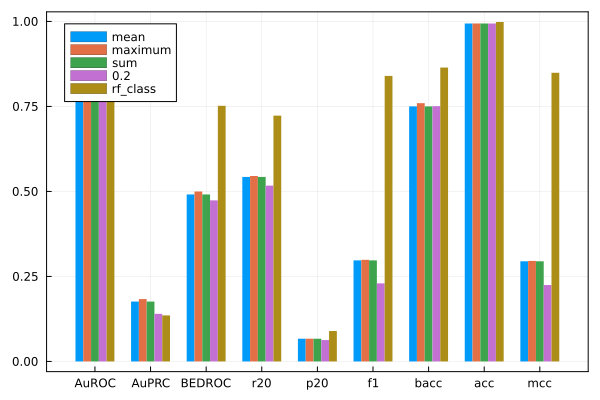

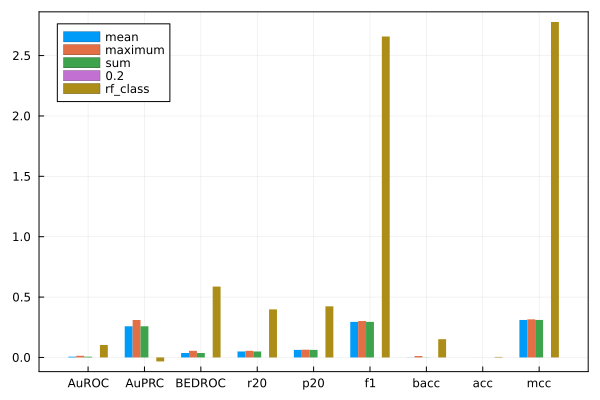

((forest = Ensemble of Decision Trees
Trees:      100
Avg Leaves: 1143.9
Avg Depth:  39.89,), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        rf_class 
     │ String  Float64?   Float64?   Float64?   Float64?   Float64? 
─────┼──────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.864249
   2 │ AuPRC   0.176055   0.183345   0.176055   0.13993    0.13532
   3 │ BEDROC  0.491086   0.49976    0.491086   0.473685   0.75177
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.722868
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.089441
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.839709
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.864265
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.998265
   9 │ mcc     0.294465   0.295586   0.294465   0.224686   0.848899, 9×6 DataFrame
 Row │ metric  mean          maximum      sum           0.2 

In [9]:
@iload RandomForestClassifier pkg=DecisionTree verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df, fxs, rf_class, "0.2")

[ Info: Training machine(RandomForestClassifier(max_depth = 10, …), …).


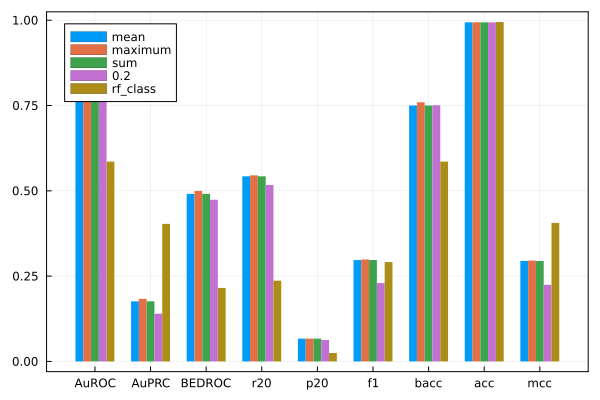

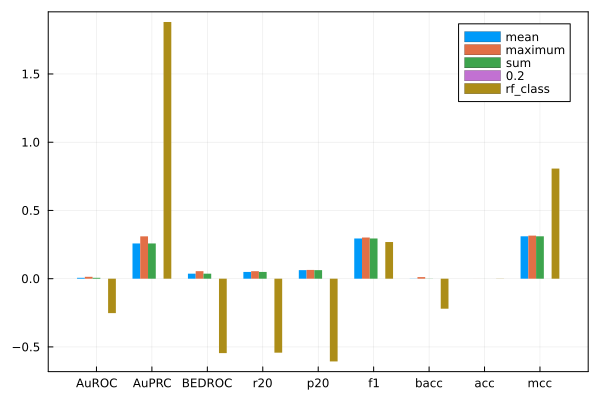

((forest = Ensemble of Decision Trees
Trees:      100
Avg Leaves: 195.61
Avg Depth:  10.0,), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        rf_class  
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?  
─────┼───────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.585693
   2 │ AuPRC   0.176055   0.183345   0.176055   0.13993    0.403126
   3 │ BEDROC  0.491086   0.49976    0.491086   0.473685   0.215394
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.236718
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.0247412
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.291221
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.585696
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.994795
   9 │ mcc     0.294465   0.295586   0.294465   0.224686   0.405979, 9×6 DataFrame
 Row │ metric  mean          maximum      sum          

In [10]:
@iload RandomForestClassifier pkg=DecisionTree verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df, fxs, rf_class, "0.2", max_depth = 10)

In [16]:
filter(
#     check for pure julia models
    m -> m.is_pure_julia && 
             contains(m.docstring * m.name, "XGBoost"),
    compatible_models
)

NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}[]


The package providing an interface to `XGBoostClassifier` is not in your current environment.
What do you want to do? 

1 - Install MLJXGBoostInterface in current environment.
2 - Abort.


stdin>  1


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Highlights ────────── v0.5.2
   Installed XGBoost_jll ───────── v1.7.4+0
   Installed CodeTracking ──────── v1.3.1
   Installed ProgressLogging ───── v0.1.4
   Installed StructTypes ───────── v1.10.0
   Installed JSON3 ─────────────── v1.12.0
   Installed LLVMOpenMP_jll ────── v15.0.4+0
   Installed SparseMatricesCSR ─── v0.6.7
   Installed MyterialColors ────── v0.3.0
   Installed MLJXGBoostInterface ─ v0.3.7
   Installed Term ──────────────── v2.0.2
   Installed XGBoost ───────────── v2.2.5
    Updating `/CLUSTERFS/homes/fnmelo/.julia/environments/v1.8/Project.toml`
  [54119dfa] + MLJXGBoostInterface v0.3.7
    Updating `/CLUSTERFS/homes/fnmelo/.julia/environments/v1.8/Manifest.toml`
  [da1fd8a2] + CodeTracking v1.3.1
  [eafb193a] + Highlights v0.5.2
  [0f8b85d8] + JSON3 v1.12.0
  [54119dfa] + MLJXGBoostInterface v0.3.7
  [1c23619d] + MyterialColors v0.3.0
  [33c8b6b6] + Progress

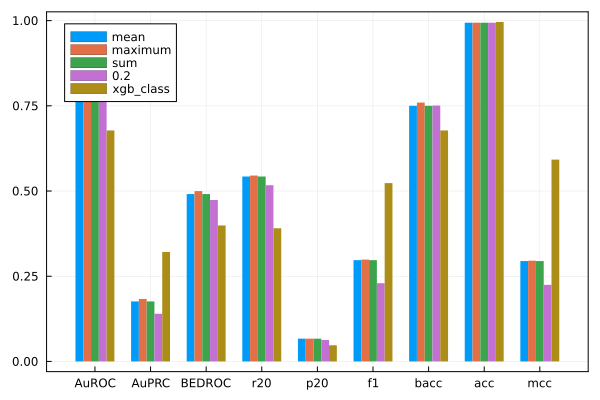

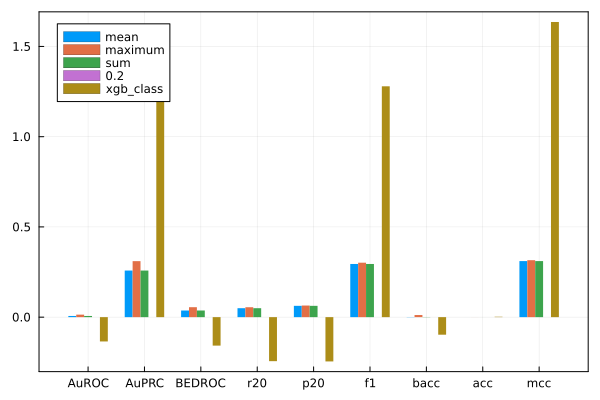

((fitresult = (XGBoost.Booster(), CategoricalArrays.CategoricalValue{Float64, UInt32} 0.0),), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        xgb_class 
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?  
─────┼───────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286    0.677717
   2 │ AuPRC   0.176055   0.183345   0.176055   0.13993     0.32126
   3 │ BEDROC  0.491086   0.49976    0.491086   0.473685    0.398919
   4 │ r20     0.542592   0.545372   0.542592   0.517002    0.390848
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364   0.047412
   6 │ f1      0.297174   0.298799   0.297174   0.229549    0.523191
   7 │ bacc    0.750061   0.759519   0.750061   0.750781    0.677721
   8 │ acc     0.993862   0.993946   0.993862   0.993846    0.995959
   9 │ mcc     0.294465   0.295586   0.294465   0.224686    0.592182, 9×6 DataFrame
 Row │ metric  mean          maximum      sum  

In [18]:
@iload XGBoostClassifier pkg=XGBoost verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df, fxs, xgb_class, "0.2")